# MULTI-VARIABLE CORONAVIRUS PROJECTIONS FOR US STATES 

In [102]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression, BayesianRidge, LinearRegression
import datetime
import matplotlib.pyplot as plt 
import warnings
import tensorflow as tf 
from scipy.stats import exponweib
%matplotlib inline

## Read the COVID tracking API 

In [4]:
data = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')
data.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200815,AK,4954.0,291723.0,NaN,36.0,NaN,NaN,NaN,4.0,...,296677,1,0,4733694e7375f7962ce3e2f348eeb04fe9422c66,0,0,0,0,0,NaN
1,20200815,AL,107580.0,729437.0,NaN,1259.0,12607.0,NaN,1313.0,NaN,...,837017,3,151,dff25f5939be1e060577775571462a80d6f22ccc,0,0,0,0,0,NaN
2,20200815,AR,51992.0,536268.0,NaN,464.0,3562.0,NaN,NaN,108.0,...,588260,13,-4,4f931e30aed5c95a10f93a7ced073232f26ec3b4,0,0,0,0,0,NaN
3,20200815,AS,0.0,1514.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1514,0,0,079bc7374b6c4bc174515e0c711d1ef337d85a48,0,0,0,0,0,NaN
4,20200815,AZ,192654.0,884537.0,NaN,1282.0,20795.0,442.0,NaN,284.0,...,1077191,69,280,d2310cf1ae2859416ae85342b7a73d78eecb4eea,0,0,0,0,0,NaN


In [8]:
data.info() #checking the data fo null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9145 entries, 0 to 9144
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9145 non-null   int64  
 1   state                        9145 non-null   object 
 2   positive                     9130 non-null   float64
 3   negative                     8989 non-null   float64
 4   pending                      1130 non-null   float64
 5   hospitalizedCurrently        6518 non-null   float64
 6   hospitalizedCumulative       5000 non-null   float64
 7   inIcuCurrently               3425 non-null   float64
 8   inIcuCumulative              1368 non-null   float64
 9   onVentilatorCurrently        2969 non-null   float64
 10  onVentilatorCumulative       486 non-null    float64
 11  recovered                    5846 non-null   float64
 12  dataQualityGrade             8044 non-null   object 
 13  lastUpdateEt      

In [15]:
data.isna().sum()

date                              0
state                             0
positive                         15
negative                        156
pending                        8015
hospitalizedCurrently          2627
hospitalizedCumulative         4145
inIcuCurrently                 5720
inIcuCumulative                7777
onVentilatorCurrently          6176
onVentilatorCumulative         8659
recovered                      3299
dataQualityGrade               1101
lastUpdateEt                    343
dateModified                    343
checkTimeEt                     343
death                           698
hospitalized                   4145
dateChecked                     343
totalTestsViral                5347
positiveTestsViral             7901
negativeTestsViral             7863
positiveCasesViral             3108
deathConfirmed                 5855
deathProbable                  6981
totalTestEncountersViral       8883
totalTestsPeopleViral          5412
totalTestsAntibody          

# Sorting data by Date chronologically

In [18]:
data.sort_values('date', inplace=True)

## Managing data insufficiency- Dropping Null Values segmentally  

In [19]:
# drop columns with 50% null values 
def drop_na_50(df):
    columns = df.columns
    for col in columns:
       if data[col].isnull().sum() > 0.5 * len(df):
         df.drop(col, 1, inplace=True)
    return df 
         
new_data = drop_na_50(data)

In [22]:
new_data.isna().sum()

date                           0
state                          0
positive                      15
negative                     156
hospitalizedCurrently       2627
hospitalizedCumulative      4145
recovered                   3299
dataQualityGrade            1101
lastUpdateEt                 343
dateModified                 343
checkTimeEt                  343
death                        698
hospitalized                4145
dateChecked                  343
positiveCasesViral          3108
fips                           0
positiveIncrease               0
negativeIncrease               0
total                          0
totalTestResults               7
totalTestResultsIncrease       0
posNeg                         0
deathIncrease                  0
hospitalizedIncrease           0
hash                           0
commercialScore                0
negativeRegularScore           0
negativeScore                  0
positiveScore                  0
score                          0
dtype: int

In [25]:
new_data.fillna(0, inplace=True)

### Consider the example of Connecticut (CT)

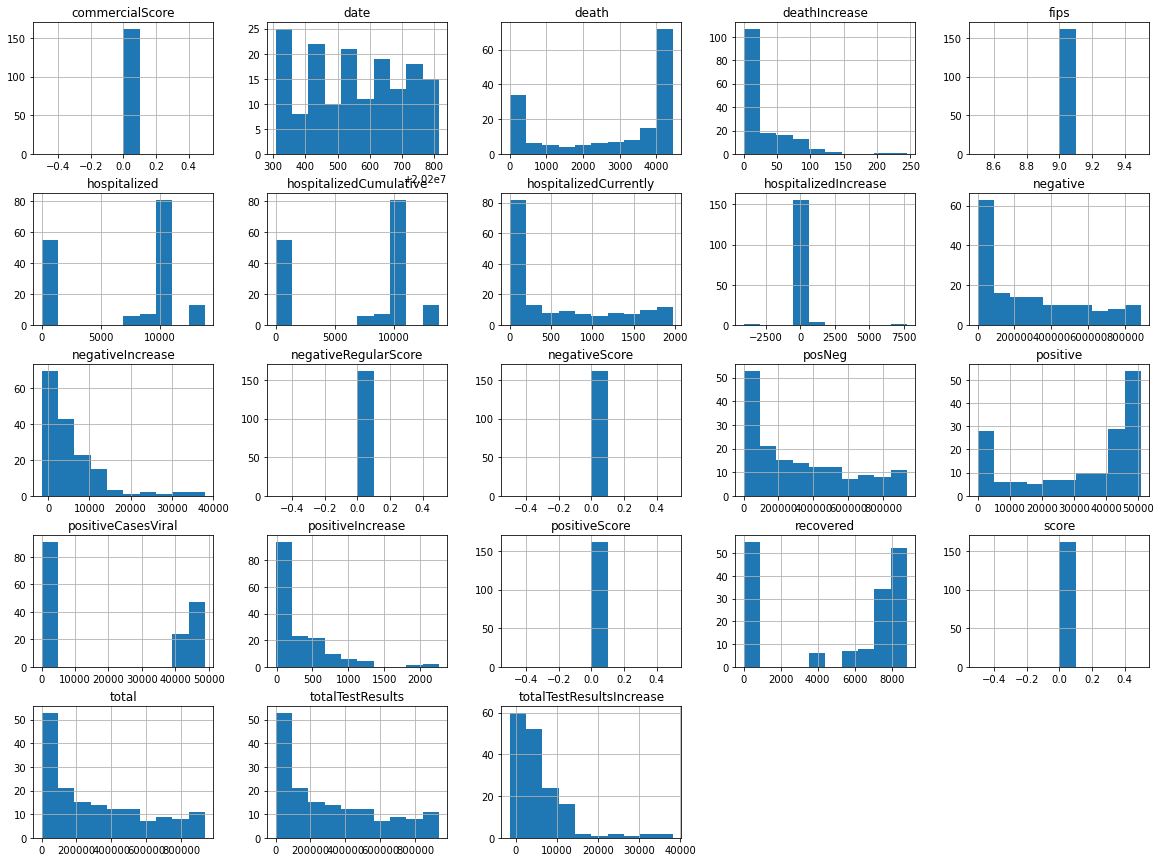

In [24]:
new_data[new_data.state=='CT'].hist(bins=10, figsize=(20, 15))
plt.show()

# Dropping the unuseful variables/features 

In [29]:
# drop variables with few/no variations
new_data.drop(['commercialScore', 'fips', 'hospitalizedIncrease', 'negativeRegularScore', 'negativeScore', 'positiveScore', 'score'], axis=1, inplace=True)

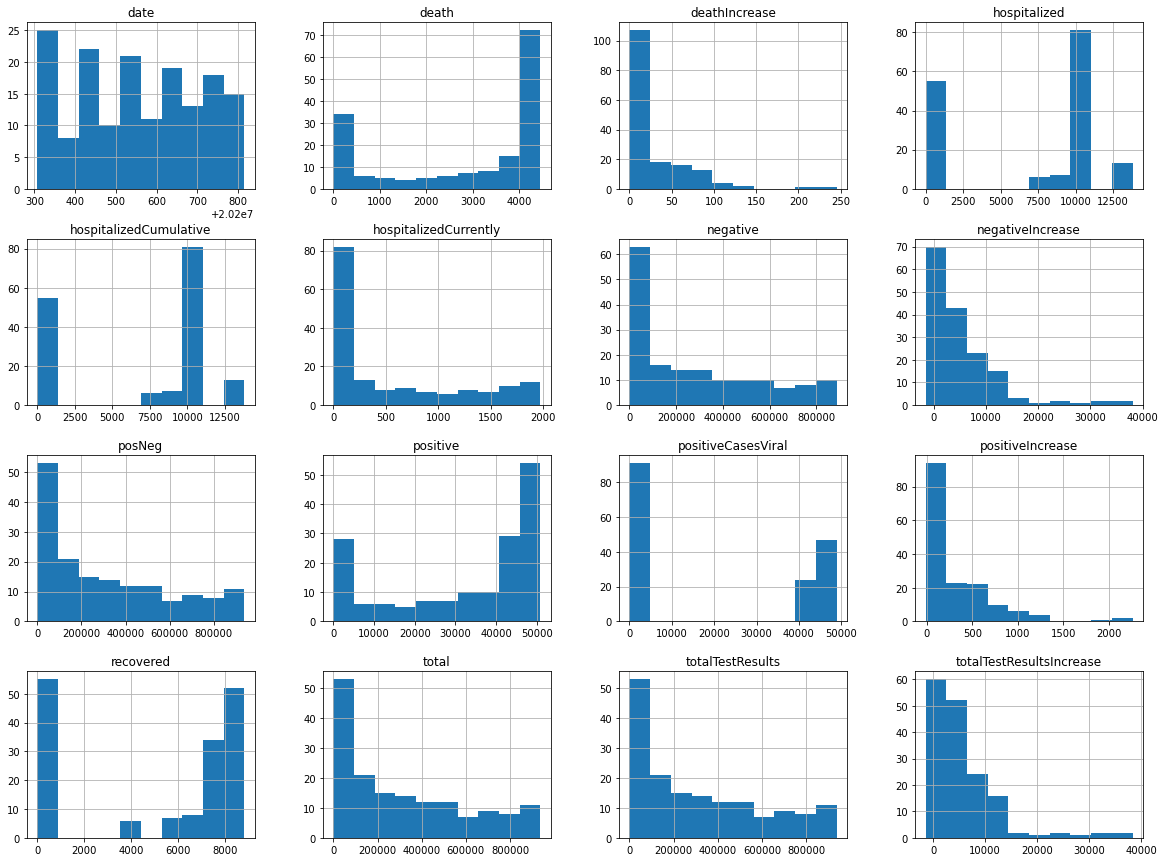

In [30]:
new_data[new_data.state=='CT'].hist(bins=10, figsize=(20, 15))
plt.show() #revisualizing Connecticut

In [33]:
new_data.isnull().sum() #BINGO!

date                        0
state                       0
positive                    0
negative                    0
hospitalizedCurrently       0
hospitalizedCumulative      0
recovered                   0
dataQualityGrade            0
lastUpdateEt                0
dateModified                0
checkTimeEt                 0
death                       0
hospitalized                0
dateChecked                 0
positiveCasesViral          0
positiveIncrease            0
negativeIncrease            0
total                       0
totalTestResults            0
totalTestResultsIncrease    0
posNeg                      0
deathIncrease               0
hash                        0
dtype: int64

### Mapping the state ames with their abbreviations for future utility 

In [52]:
# dictonary for mapping state to abbreviation 
us_state_abbrev = {
    'Alaska': 'AK',
    'Alabama': 'AL',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [53]:
us_state_abbrev['Connecticut'] # checking if the mapping is successful

'CT'

### Loading additional state information for population density, specifially  

In [54]:
# this data frame is going to provide static variables
additional_data = pd.read_csv('./COVID19_state.csv')
additional_data.head()

,State,Tested,Infected,Deaths,Population,Pop Density,Gini,ICU Beds,Income,GDP,...,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,School Closure Date
0,Alaska,36380,399,10,734002,1.2863,0.4081,119,59687,73205,...,21,11064,6.4,1.0,26.6,66.0,0.36,0.39,0.25,03/19/20
1,Alabama,157566,12376,504,4908621,96.9221,0.4847,1533,42334,45219,...,101,7281,8.1,1.0,62.8,59.0,0.33,0.37,0.31,03/16/20
2,Arkansas,93701,4923,102,3038999,58.4030,0.4719,732,42566,42454,...,88,7408,7.1,0.0,60.4,56.2,0.34,0.37,0.30,03/17/20
3,Arizona,220612,14566,704,7378494,64.9550,0.4713,1559,43650,48055,...,83,6452,9.7,1.0,60.3,89.8,0.33,0.36,0.30,03/16/20
4,California,1339316,81795,3334,39937489,256.3727,0.4899,7338,62586,74205,...,359,7549,12.8,9.0,59.4,95.0,0.33,0.40,0.26,03/19/20


In [42]:
additional_data.isnull().sum()

State                  0
Tested                 0
Infected               0
Deaths                 0
Population             0
Pop Density            0
Gini                   0
ICU Beds               0
Income                 0
GDP                    0
Unemployment           0
Sex Ratio              0
Smoking Rate           0
Flu Deaths             0
Respiratory Deaths     0
Physicians             0
Hospitals              0
Health Spending        0
Pollution              0
Med-Large Airports     0
Temperature            0
Urban                  0
Age 0-25               0
Age 26-54              0
Age 55+                0
School Closure Date    3
dtype: int64

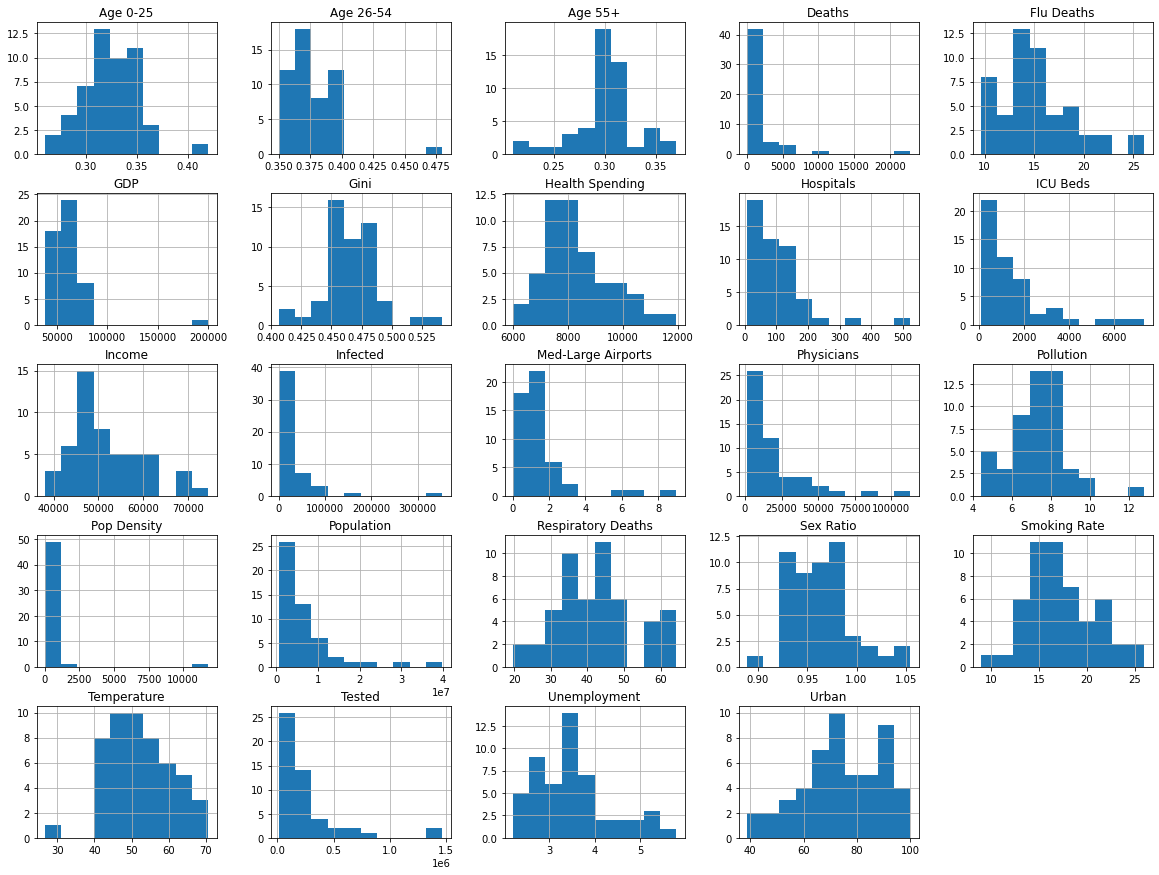

In [44]:
additional_data.hist(bins=10, figsize=(20, 15))
plt.show()

# Using the dictionary we created before to ensure that data are consistent 

In [55]:
for i in additional_data.State.unique():
    additional_data.replace(i, us_state_abbrev[i], inplace=True)

In [56]:
additional_data.State.unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [57]:
additional_data.head()

,State,Tested,Infected,Deaths,Population,Pop Density,Gini,ICU Beds,Income,GDP,...,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,School Closure Date
0,AK,36380,399,10,734002,1.2863,0.4081,119,59687,73205,...,21,11064,6.4,1.0,26.6,66.0,0.36,0.39,0.25,03/19/20
1,AL,157566,12376,504,4908621,96.9221,0.4847,1533,42334,45219,...,101,7281,8.1,1.0,62.8,59.0,0.33,0.37,0.31,03/16/20
2,AR,93701,4923,102,3038999,58.4030,0.4719,732,42566,42454,...,88,7408,7.1,0.0,60.4,56.2,0.34,0.37,0.30,03/17/20
3,AZ,220612,14566,704,7378494,64.9550,0.4713,1559,43650,48055,...,83,6452,9.7,1.0,60.3,89.8,0.33,0.36,0.30,03/16/20
4,CA,1339316,81795,3334,39937489,256.3727,0.4899,7338,62586,74205,...,359,7549,12.8,9.0,59.4,95.0,0.33,0.40,0.26,03/19/20


### Taking a look at Califoria's Popuation Density

In [58]:
additional_data[additional_data.State=='CA']['Pop Density']

4    256.3727
Name: Pop Density, dtype: float64

In [59]:
pop_dense = []
for i in new_data.state:
    pop_dense.append(additional_data[additional_data.State==i]['Pop Density'].sum())

In [61]:
new_data['pop_dense'] = pop_dense
new_data['pop_dense'].head()

9144    117.3272
9143    117.3272
9142    117.3272
9141    117.3272
9140    117.3272
Name: pop_dense, dtype: float64

### Scaling the popluation density between 0 and 1 to normalize data 

In [63]:
# scales the population density based on all the states 
min_max_scaler = MinMaxScaler()
new_data['pop_dense'] = min_max_scaler.fit_transform(np.array(new_data['pop_dense']).reshape(-1, 1))
new_data['pop_dense'].head()

9144    0.009931
9143    0.009931
9142    0.009931
9141    0.009931
9140    0.009931
Name: pop_dense, dtype: float64

In [65]:
new_data['pop_dense'].describe() #Validation:)

count    9145.000000
mean        0.033422
std         0.132416
min         0.000000
25%         0.003013
50%         0.008204
75%         0.018616
max         1.000000
Name: pop_dense, dtype: float64

# Coming to the most useful and leveraging data- 'mobility trends' 

In [72]:
#this dataset is going to provide mobility information within the US

mobility_data = pd.read_csv('./applemobilitytrends-2020-08-13.csv')
mobility_data.head()

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,...,193.56,201.82,187.74,203.09,218.60,234.00,230.14,215.44,216.40,232.93
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,...,140.26,152.96,144.52,150.49,151.17,140.72,163.50,166.27,168.27,161.58
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,...,57.82,58.69,57.83,66.13,63.37,36.89,55.64,57.49,59.57,60.74
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,...,49.23,47.49,43.61,48.15,48.86,27.78,43.74,45.29,46.27,47.79
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,...,88.74,87.77,92.37,90.20,73.91,78.69,82.83,85.36,89.13,95.89


In [70]:
mobility_data.isnull().sum() #checking null entries-beginning the cleaning  

geo_type                  0
region                    0
transportation_type       0
alternative_name       2892
sub-region              844
                       ... 
2020-08-09               39
2020-08-10               39
2020-08-11               39
2020-08-12               39
2020-08-13               39
Length: 220, dtype: int64

In [73]:
mobility_data['sub-region'].unique()

array([nan, 'North Rhine-Westphalia', 'South Australia', 'Ohio',
       'New York', 'New Mexico', 'Pennsylvania', 'North Holland',
       'Alaska', 'Michigan', 'Maryland', 'California', 'Antwerp Province',
       'Attica', 'Georgia', 'Auckland Region', 'Bavaria', 'Texas',
       'Catalonia', 'Canton of Basel-Stadt', 'Northern Ireland',
       'Minas Gerais', 'Lombardy Region', 'Canton of Bern', 'Alabama',
       'England', 'Idaho', 'Emilia-Romagna Region', 'Aquitaine Region',
       'Massachusetts', 'Bremen (state)', 'Connecticut', 'Queensland',
       'Alberta', 'Western Cape', 'Wales', 'Sicily Region',
       'North Carolina', 'Illinois', 'Colorado', 'South Carolina',
       'Capital Region of Denmark', 'Paraná', 'Iowa', 'Saxony',
       'Scotland', 'North Brabant', 'Oregon', 'Tuscany Region', 'Indiana',
       'Ceará', 'Hesse', 'Shizuoka Prefecture', 'Fukuoka Prefecture',
       'Pomerania Province', 'Canton of Geneva', 'Goiás',
       'Västra Götaland County', 'Styria', 'Rhône-Alpe

In [75]:
# good that we have data from our other US states' data to be utilised and mapped with 

In [76]:
# make the data consistent with the other data frame 
for i in mobility_data['sub-region'].unique():
    if i in us_state_abbrev.keys():
        mobility_data.replace(i, us_state_abbrev[i], inplace=True)

In [77]:
mobility_data['transportation_type'].unique() #checking the unique transportation types  

array(['driving', 'walking', 'transit'], dtype=object)

## making sure that data from mobility matches others 

In [78]:
# get individual states and dates
unique_states = new_data.state.unique()
unique_states.sort()
unique_dates = new_data.date.unique()

# making sure that the dates match between mobility and testing/cases
mobility_latest_date = datetime.datetime.strptime(mobility_data.columns[-1], '%Y-%m-%d').strftime('%Y%m%d')
mobility_latest_index = np.where(unique_dates == int(mobility_latest_date))[0][0]

# start from a later date 3/1/2020
unique_dates = unique_dates[39:mobility_latest_index+1]

In [100]:
# IMP! a SIMPLE function that gets the mobility information of a particular day
def get_mobility_by_state(transport_type, state, day):
    return mobility_data[mobility_data['sub-region']==state][mobility_data['transportation_type']==transport_type].sum()[day]
get_mobility_by_state('walking', 'FL', '2020-03-01')

<ipython-input-100-e7ed110de7ae>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mobility_data[mobility_data['sub-region']==state][mobility_data['transportation_type']==transport_type].sum()[day]


645.5

### we require the date formats to match in all files too

In [86]:
# change the date format to match the mobility data 
revised_unique_dates = [] 
for i in range(len(unique_dates)):
    revised_unique_dates.append(datetime.datetime.strptime(str(unique_dates[i]), '%Y%m%d').strftime('%Y-%m-%d'))
revised_unique_dates# change the date format to match the mobility data 
revised_unique_dates = [] 
for i in range(len(unique_dates)):
    revised_unique_dates.append(datetime.datetime.strptime(str(unique_dates[i]), '%Y%m%d').strftime('%Y-%m-%d'))
revised_unique_dates

['2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05',
 '2020-04-06',
 '2020-04-07',
 '2020-04-08',
 '2020-04-09',
 '2020-04-10',
 '2020-04-11',
 '2020-04-12',
 '2020-04-13',
 '2020-04-14',
 '2020-04-15',
 '2020-04-16',
 '2020-04-17',
 '2020-04-18',
 '2020-04-19',
 '2020-04-20',
 '2020-04-21',
 '2020-04-22',
 '2020-04-23',
 '2020-04-24',
 '2020-04-25',
 '2020-04-26',
 '2020-04-27',
 '2020-04-28',
 '2020-04-29',
 '2020-04-30',
 '2020-05-01',
 '2020-05-02',
 '2020-05-03',
 '2020-05-04',
 '2020-05-05',
 '2020-05-

### now, let's take a look at Florida's mobility at any random date  

In [87]:
print(get_mobility_by_state('transit', 'FL', revised_unique_dates[9]))

482.04


<ipython-input-83-eac40dc32060>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mobility_data[mobility_data['sub-region']==state][mobility_data['transportation_type']==transport_type].sum()[day]


## converting dates to numeric data 

In [88]:
def convert_date_to_int(d):
    return [i for i in range(len(revised_unique_dates))]

days_since_3_1 = convert_date_to_int(revised_unique_dates)

## let's predict 10 days into the future for decent results  

In [89]:
days_ahead = 10
future_dates = [i for i in range(len(revised_unique_dates)+days_ahead)]

# SVM Implementation of prediction model

In [91]:
def svm_reg(X_train, X_test, y_train, y_test, future_forecast, state):
        
    svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1, degree=4, C=0.1)
    svm_confirmed.fit(X_train, y_train)
    test_svm_pred = svm_confirmed.predict(X_test)
    svm_pred = svm_confirmed.predict(future_forecast)
    
    plt.plot(y_test)
    plt.plot(test_svm_pred)
    plt.title('Testing Set Evaluation for {}'.format(state))
    plt.xlabel('Days since 3/1/2020')
    plt.ylabel('# of positive coronavirus cases')
    plt.legend(['Actual', 'Predicted'])
    plt.show()
    
    print('MAE:', mean_absolute_error(test_svm_pred, y_test))
    print('MSE:',mean_squared_error(test_svm_pred, y_test))

    # plot the graph to see compare predictions and actual coronavirus cases
    plt.plot(positive)
    plt.plot(svm_pred)
    plt.title('Coronavirus Cases in {}'.format(state))
    plt.legend(['Actual cases', 'Predicted cases using support vector regression'])
    plt.xlabel('Days since 3/1/2020')
    plt.ylabel('# of positive coronavirus cases')
    plt.show()
    print('Completed:', state)

# Bayesian Ridge Implementation of the Prediction Model

In [92]:
def bayesian_ridge(X_train, X_test, y_train, y_test, future_forecast, state):
        
    # convert data to be compatible with polynomial regression
    bayesian_poly = PolynomialFeatures(degree=3)
    bayesian_poly_X_train = bayesian_poly.fit_transform(X_train)
    bayesian_poly_X_test = bayesian_poly.fit_transform(X_test)
    bayesian_poly_future_forecast = bayesian_poly.fit_transform(future_forecast)
    
    # polynomial regression model
    # bayesian ridge polynomial regression
    tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    normalize = [True, False]
    fit_intercept = [True,  False]
    lambda_init = [1e-2, 1e-1, 1, 1e1]

    bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                    'normalize' : normalize, 'fit_intercept': fit_intercept, 'lambda_init' : lambda_init}

    bayesian = BayesianRidge()
    bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=200, verbose=1)
    bayesian_search.fit(bayesian_poly_X_train, y_train)
    
    # get the best estimator 
    best_params = bayesian_search.best_params_
    bayesian_confirmed = BayesianRidge(**best_params)
    bayesian_confirmed.fit(bayesian_poly_X_train, y_train)
    
    test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test)
    bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forecast)
    
    plt.plot(y_test)
    plt.plot(test_bayesian_pred)
    plt.title('Testing Set Evaluation for {}'.format(state))
    plt.xlabel('Days since 3/1/2020')
    plt.ylabel('# of positive coronavirus cases')
    plt.legend(['Actual', 'Predicted'])
    plt.show()
    
    print('MAE:', mean_absolute_error(test_bayesian_pred, y_test))
    print('MSE:',mean_squared_error(test_bayesian_pred, y_test))
    print('Weight:', bayesian_confirmed.coef_)

    # plot the graph to see compare predictions and actual coronavirus cases
    plt.plot(positive)
    plt.plot(bayesian_pred)
    plt.title('Coronavirus Cases in {}'.format(state))
    plt.legend(['Actual cases', 'Predicted cases using bayesian ridge'])
    plt.xlabel('Days since 3/1/2020')
    plt.ylabel('# of positive coronavirus cases')
    plt.show()
    print('Completed:', state)

In [93]:
# helper function for finding daily change 
def daily_change(y2, y1):
    return (y2-y1)

## Taking Moving Averages instead of single day  for coronavirus cases - the good thing  

In [94]:
# get moving average for positive case 

def moving_positive_cases(data, window_size):
    moving_positive = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_positive.append(np.mean(data[i:i+window_size]))
        else:
            moving_positive.append(np.mean(data[i:len(data)]))
    return moving_positive

## extrapolating testing information using polynomial regression 

In [95]:
def future_testing_extrapolation(X, y, future_forecast, state):
    poly = PolynomialFeatures(degree=3)
    poly_X = poly.fit_transform(X)
    poly_future_forecast = poly.fit_transform(future_forecast)
    
    poly_confirmed = LinearRegression(fit_intercept=True, normalize=True)
    poly_confirmed.fit(poly_X, y)
    
    poly_pred = poly_confirmed.predict(poly_future_forecast)
    
    plt.plot(y)
    plt.plot(poly_pred)
    plt.title('Coronavirus testing in {}'.format(state))
    plt.legend(['Actual testing', 'Predicted testing using polynomial regression'])
    plt.xlabel('Days since 3/1/2020')
    plt.ylabel('# of testing')
    plt.show()
    
    future_increases = [] 
    
    # calulate future rates of change 
    for i in range(days_ahead):
        c = len(X) - 1
        future_increases.append(daily_change(poly_pred[c+i+1], poly_pred[c+i]))
    return future_increases

#### reshaping our arrays for sklearn 

In [96]:
days_since_3_1 = np.array(days_since_3_1).reshape(-1, 1)
future_dates = np.array(future_dates).reshape(-1, 1)

## taking window averages for our mobility data - the other good thing 

In [97]:
def window_average(window_size, data, method):
    avg_data = [] 
    date_length = len(data)
    
    for i in range(len(data)):
        remainder = i % window_size 
        if method == 'median':
            if i - remainder + window_size - 1 < date_length:
                avg_data.append(np.median(data[i-remainder:i-remainder+window_size-1]))
            else:
                delta = date_length % window_size 
                avg_data.append(np.median(data[date_length-delta-1:date_length-1]))
        elif method == 'mean':
             if i - remainder + window_size - 1 < date_length:
                avg_data.append(np.mean(data[i-remainder:i-remainder+window_size-1]))
             else:
                delta = date_length % window_size 
                avg_data.append(np.mean(data[date_length-delta-1:date_length-1]))
        else:
            warnings.warn('Methods can only be mean or median')
            
    return avg_data

### differentiating between weekends and weekdays 

In [98]:
# returns true if it is a weekend, and false if it is a weekday 
def weekday_or_weekend(date):
    date_obj = datetime.datetime.strptime(str(date), '%Y%m%d')
    day_of_the_week =  date_obj.weekday()
    if (day_of_the_week+1) % 6 == 0 or (day_of_the_week+1) % 7 == 0:
        return True 
    else:
        return False 

# BUILDING THE MODEL! 

<ipython-input-99-b8193c3cf04f>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].positive.sum())
<ipython-input-99-b8193c3cf04f>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].totalTestResults.sum())
<ipython-input-83-eac40dc32060>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mobility_data[mobility_data['sub-region']==state][mobility_data['transportation_type']==transport_type].sum()[day]


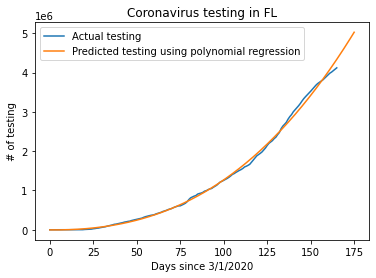

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   13.2s finished
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


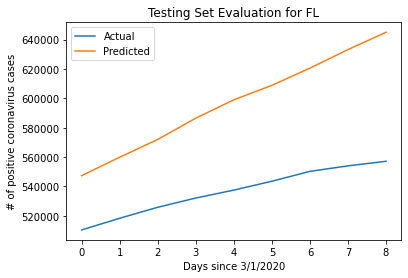

MAE: 60366.43147584603
MSE: 3907688626.9545965
Weight: [ 1.19133465e-01  4.32169903e+00  4.13555943e-03  2.13635539e-02
  1.10589390e-01  1.49954990e-01  5.15384631e+00  1.50021853e-01
  2.10601926e+00  1.34088591e+00  4.72617905e+00  1.43516254e-04
  7.41645864e-04  3.83893385e-03  5.20545339e-03  1.81003326e-03
  1.83305487e-02  2.05580453e-02  2.94288874e-02  1.10714309e-01
  1.58437899e-01 -1.72344833e-01  1.78908710e-01  4.49503736e+01
 -3.21791042e+00  1.14280543e+01  5.20778747e-03  7.31075787e-02
  4.65470239e-02  1.64062802e-01 -2.70465815e+00  2.43862405e+00
  2.03275639e+00 -6.79556785e-01  1.33752445e+00  4.76827443e+00
  4.98042901e-06  2.57433569e-05  1.33264097e-04  1.80700374e-04
  6.28309717e-05  6.36320918e-04  7.13647334e-04  1.02159051e-03
  3.84329104e-03  5.49995723e-03 -3.70187427e-02  4.49595208e-03
  1.74629422e-03  1.88771764e-02  1.77277249e-02  1.97818133e-02
 -1.93061149e-03  2.99679025e-02  1.07190122e-01  1.60453436e-01]


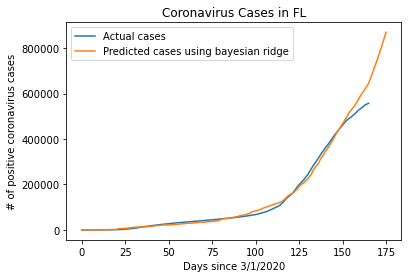

Completed: FL


<ipython-input-99-b8193c3cf04f>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].positive.sum())
<ipython-input-99-b8193c3cf04f>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].totalTestResults.sum())
<ipython-input-83-eac40dc32060>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mobility_data[mobility_data['sub-region']==state][mobility_data['transportation_type']==transport_type].sum()[day]


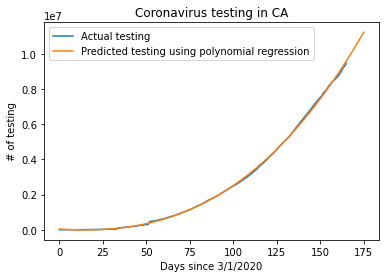

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.4s finished
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


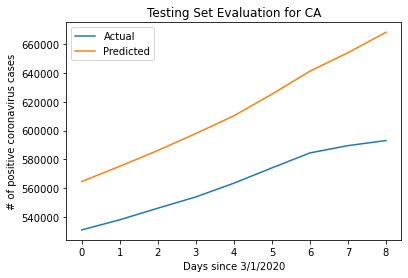

MAE: 49954.91959999799
MSE: 2659052268.663201
Weight: [-4.69455933e-02 -4.32824652e-01 -1.01870629e-03  9.19991197e-03
  4.85332493e-02 -2.65752934e-02  2.34278499e-02 -9.39221107e-03
  9.02577464e-01  1.09489922e+00  1.85180826e-01 -2.21200121e-05
  1.99642068e-04  1.05316839e-03 -5.76670201e-04  3.31817060e-04
  8.17642541e-03  9.22269578e-03  1.94811829e-02  4.60221949e-02
 -6.80828228e-03 -2.84953351e-02  5.08376957e-04  1.99983165e+01
 -4.03832782e+00  1.61896393e+01 -2.03815401e-04  1.95857094e-02
  2.37590676e-02  4.01837524e-03 -1.09948086e+00  9.74118326e-01
  9.02674283e-01 -5.79527369e-01  1.07012022e+00  6.70438903e-01
 -4.79390091e-07  4.33260310e-06  2.28532712e-05 -1.25139719e-05
  7.19988928e-06  1.77426717e-04  2.00130057e-04  4.22736996e-04
  9.98669957e-04 -1.47736750e-04 -1.47971160e-02  1.00059442e-03
  3.31333465e-04  7.90945725e-03  8.17247113e-03  9.23546052e-03
 -4.51561172e-03  1.86146030e-02  4.63568007e-02  6.64375993e-03]


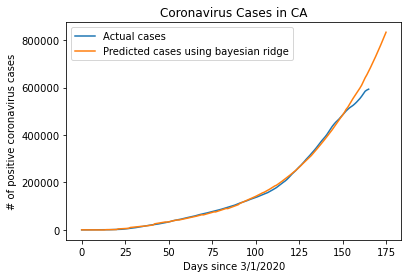

Completed: CA


<ipython-input-99-b8193c3cf04f>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].positive.sum())
<ipython-input-99-b8193c3cf04f>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].totalTestResults.sum())
<ipython-input-83-eac40dc32060>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mobility_data[mobility_data['sub-region']==state][mobility_data['transportation_type']==transport_type].sum()[day]


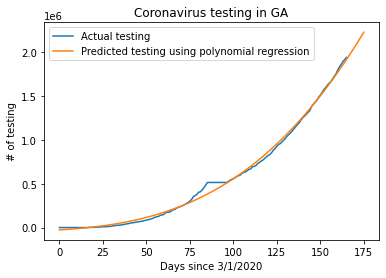

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.0s finished
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


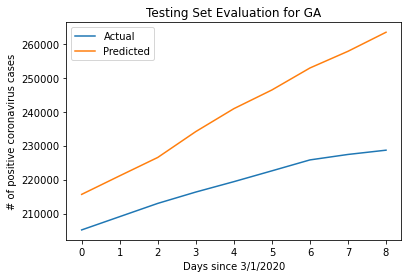

MAE: 21242.693401781744
MSE: 515421551.180001
Weight: [ 1.89337691e-02  5.33140227e-01  2.99129640e-04  1.72533138e-02
  1.72450954e-01 -7.81103693e-02 -4.96501729e+00  8.42370845e-03
  1.05317961e+00  4.80277471e+00  1.11604285e-01  4.71270811e-06
  2.72588951e-04  2.72482068e-03 -1.23416833e-03 -2.13530191e-03
  1.24081263e-02  1.76841037e-02  9.31093989e-02  1.42276189e-01
 -4.54847214e-02 -3.98973842e-02 -7.84481929e-02  1.13769142e+01
 -5.34058186e+00  1.66917626e+01  1.33094351e-04  1.66404579e-02
  7.58847096e-02  1.76335427e-03 -1.60201521e+00  7.90154105e-01
  1.06791737e+00 -9.87812419e-05  4.51556685e+00  1.27896967e+00
  7.31568269e-08  4.30626820e-06  4.30519876e-05 -1.95012826e-05
 -3.37373775e-05  1.96050185e-04  2.79412733e-04  1.47114805e-03
  2.24798470e-03 -7.18666800e-04 -1.99822220e-02 -1.97636019e-03
 -2.13025990e-03  6.28890143e-03  1.24404925e-02  1.80675962e-02
  1.74413227e-02  8.25914909e-02  1.44471018e-01 -1.12133682e-02]


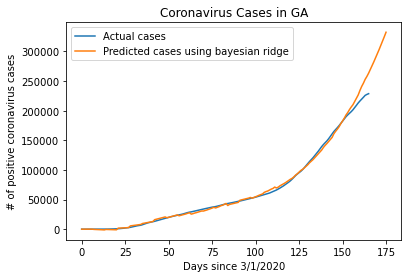

Completed: GA


<ipython-input-99-b8193c3cf04f>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].positive.sum())
<ipython-input-99-b8193c3cf04f>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].totalTestResults.sum())
<ipython-input-83-eac40dc32060>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mobility_data[mobility_data['sub-region']==state][mobility_data['transportation_type']==transport_type].sum()[day]


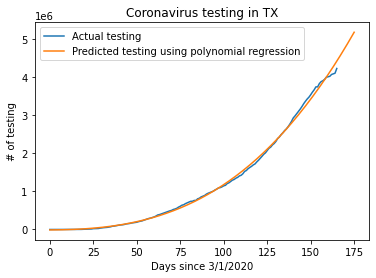

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.4s finished
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


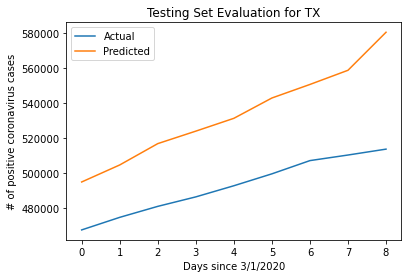

MAE: 41362.163149213404
MSE: 1831793913.6535523
Weight: [ 9.58163128e-02  2.89886388e+00  9.14979776e-04  5.76393193e-03
  5.01687474e-02  1.08532954e-01  3.85800753e+00  2.76821007e-02
  5.83160680e-01  6.39730375e-01  3.00672153e+00  8.72323834e-06
  5.50473326e-05  4.79062378e-04  1.03641398e-03 -1.18417522e-03
  7.24608745e-03  5.64831727e-03  1.96951421e-02  5.23626418e-02
  1.10282447e-01 -3.14961023e-02  3.68412095e-02  2.33175080e+01
  1.89391286e-01  2.66132956e+00  2.64343932e-04  5.56876309e-03
  6.10896437e-03  2.87120364e-02 -1.02917814e+00  9.99302068e-01
  5.75851054e-01  6.80235771e-02  6.45009291e-01  2.96717803e+00
  8.31585410e-08  5.25769045e-07  4.57494759e-06  9.89679147e-06
 -1.13075005e-05  6.91938045e-05  5.39367293e-05  1.88078000e-04
  5.00024523e-04  1.05311385e-03 -1.38009308e-02  2.55951198e-04
 -1.17783141e-03  1.02977648e-02  7.18115165e-03  5.54272538e-03
  8.74676956e-03  2.10345099e-02  5.17366211e-02  1.10042211e-01]


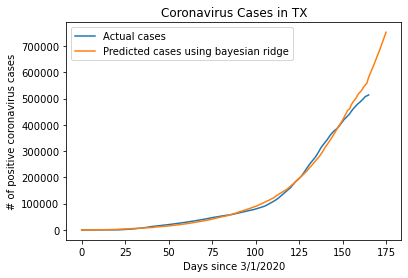

Completed: TX


<ipython-input-99-b8193c3cf04f>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].positive.sum())
<ipython-input-99-b8193c3cf04f>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].totalTestResults.sum())
<ipython-input-83-eac40dc32060>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mobility_data[mobility_data['sub-region']==state][mobility_data['transportation_type']==transport_type].sum()[day]


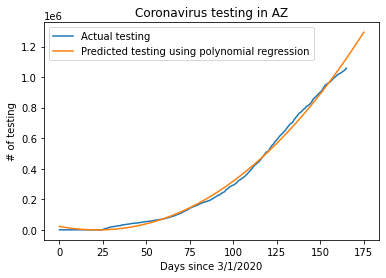

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.4s finished
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


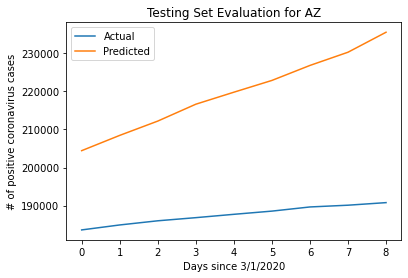

MAE: 32058.027686039502
MSE: 1082831485.1280081
Weight: [ 2.66940110e-02 -4.44568038e-01  1.46757036e-04  2.58733155e-02
 -1.07760359e-01  5.44066898e-02  6.67853540e+00 -2.44418452e-03
  2.34750966e+00 -4.53776639e+00 -4.71516830e-01  8.07468548e-07
  1.42240447e-04 -5.92454794e-04  2.99126191e-04  3.68651063e-03
  2.57406013e-02  2.54333821e-02 -9.89850732e-02 -9.42196953e-02
  4.31348419e-02 -3.89457174e-02  3.67178206e-02  1.12397713e+01
  7.04947322e+00 -7.86533398e+00 -1.34449576e-05  1.29063383e-02
 -2.49481162e-02 -2.59233669e-03 -1.81152800e+00  2.64629002e+00
  2.33136797e+00 -2.77639362e+00 -4.42736825e+00 -9.33085301e-01
  4.62996599e-09  7.82014056e-07 -3.25736393e-06  1.64444841e-06
  2.02679320e-05  1.41518907e-04  1.39829884e-04 -5.44208775e-04
 -5.18008885e-04  2.37149853e-04 -2.13101132e-02  4.74839130e-03
  3.67508296e-03  2.92319957e-02  2.56870924e-02  2.51029547e-02
 -7.04244536e-02 -9.19785260e-02 -9.51485510e-02  3.13999828e-02]


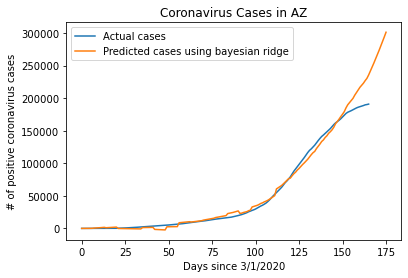

Completed: AZ


In [99]:
states = ['FL', 'CA', 'GA', 'TX', 'AZ']

for state in states:
    positive = []
    pop_density = [] 
    testing = [] 
    
    # mobility data
    walking_weekday = [] 
    walking_weekend = [] 
    walking = []
    walking_weekday_window = 7
    walking_weekend_window = 7
    
    # adjust window size for mobility
    
    date_length = len(revised_unique_dates)
    
    # get cases in sequential order for each state
    for i in range(date_length):
        positive.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].positive.sum())
        pop_density.append(new_data[new_data.state==state]['pop_dense'].max())
        testing.append(new_data[new_data.date==unique_dates[i]][new_data.state==state].totalTestResults.sum())
        
        # determines if it is a weekend or weekday 
        if weekday_or_weekend(unique_dates[i]): 
            walking_weekend.append(get_mobility_by_state('walking', state, revised_unique_dates[i]))
        else:
            walking_weekday.append(get_mobility_by_state('walking', state, revised_unique_dates[i]))
        
#         remainder = i % window_size 
#         if i - remainder + window_size < date_length:
#             walking.append(get_mobility_by_state('walking', state, revised_unique_dates[i-remainder], revised_unique_dates[i-remainder+window_size-1], 'median'))
#         else:
#             # if extrapolating use the mobility average from the last few days based on the window size
#             delta = date_length % window_size 
#             walking.append(get_mobility_by_state('walking', state, revised_unique_dates[date_length-delta-1], revised_unique_dates[date_length-1], 'median'))


    # remove any decreases in cum testing and positive cases
    for i in range(len(testing)):
        if i != 0:
            if testing[i] < testing[i-1]:
                testing[i] = testing[i-1]
            if positive[i] < positive[i-1]:
                positive[i] = positive[i-1]
    
    # remove 0 in mobility from both weekday and weekend data (there are few null values from Apple's mobility data)
    for i in range(len(walking_weekend)):       
        if walking_weekend[i] == 0 and i != 0:
            walking_weekend[i] = walking_weekend[i-1]
            
    for i in range(len(walking_weekday)):
        if walking_weekday[i] == 0 and i != 0:
            walking_weekday[i] = walking_weekday[i-1]
            
    
    # taking window average for mobility 
    walking_weekday_avg = window_average(7, walking_weekday, 'mean')
    walking_weekend_avg = window_average(7, walking_weekend, 'mean')

    
    # making sure the shape of the mobility arrays match 
    r_walking_weekday_avg = [] 
    r_walking_weekend_avg = [] 
    
    k = 0 
    j = 0 
    for i in range(date_length):
        if i % walking_weekday_window == 0 and i != 0:
            if k + walking_weekday_window < len(walking_weekday_avg):
                k += walking_weekday_window
            else:
                k = len(walking_weekday_avg) - 1 
                
            if j + walking_weekend_window < len(walking_weekend_avg):
                j += walking_weekend_window
            else:
                j = len(walking_weekend_avg) - 1
        
        r_walking_weekday_avg.append(walking_weekday_avg[k])
        r_walking_weekend_avg.append(walking_weekend_avg[j])
        

    # take moving average for positive cases
    positive = moving_positive_cases(positive, 3)

    # future testing extrapolations from poylnomial prediction 
    future_testing = future_testing_extrapolation(days_since_3_1, testing, future_dates, state)
    for i in future_testing:
        testing.append(testing[-1] + i)
    
    testing = np.array(testing).reshape(-1, 1)
    positive = np.array(positive).reshape(-1, 1)
    r_walking_weekday_avg = np.array(r_walking_weekday_avg).reshape(-1, 1)
    r_walking_weekend_avg = np.array(r_walking_weekend_avg).reshape(-1, 1)
    
    min_max_scaler = MinMaxScaler()
    testing = min_max_scaler.fit_transform(testing)
    r_walking_weekday_avg = min_max_scaler.fit_transform(r_walking_weekday_avg)
    r_walking_weekend_avg = min_max_scaler.fit_transform(r_walking_weekend_avg)
    
    # combining the two features
    X = [] 
    future_forecast = []
    
    for i in range(len(days_since_3_1)):
        X.append([days_since_3_1[i][0], pop_density[0], testing[i][0], r_walking_weekday_avg[i][0], r_walking_weekend_avg[i][0]])
    
    X = np.array(X, object).reshape(-1, 5)
    
    for i in range(len(future_dates)):
        if i < date_length:
            future_forecast.append([future_dates[i][0], pop_density[0], testing[i][0], r_walking_weekday_avg[i][0], r_walking_weekend_avg[i][0]])
        else:
            future_forecast.append([future_dates[i][0], pop_density[0], testing[i][0], r_walking_weekday_avg[-1][0], r_walking_weekend_avg[-1][0]])
            
    future_forecast = np.array(future_forecast, object).reshape(-1, 5)
    
    # splitting into training and testing sets 
    X_train, X_test, y_train, y_test = train_test_split(X, positive, shuffle=False, test_size=0.05)
    bayesian_ridge(X_train, X_test, y_train, y_test, future_forecast, state)

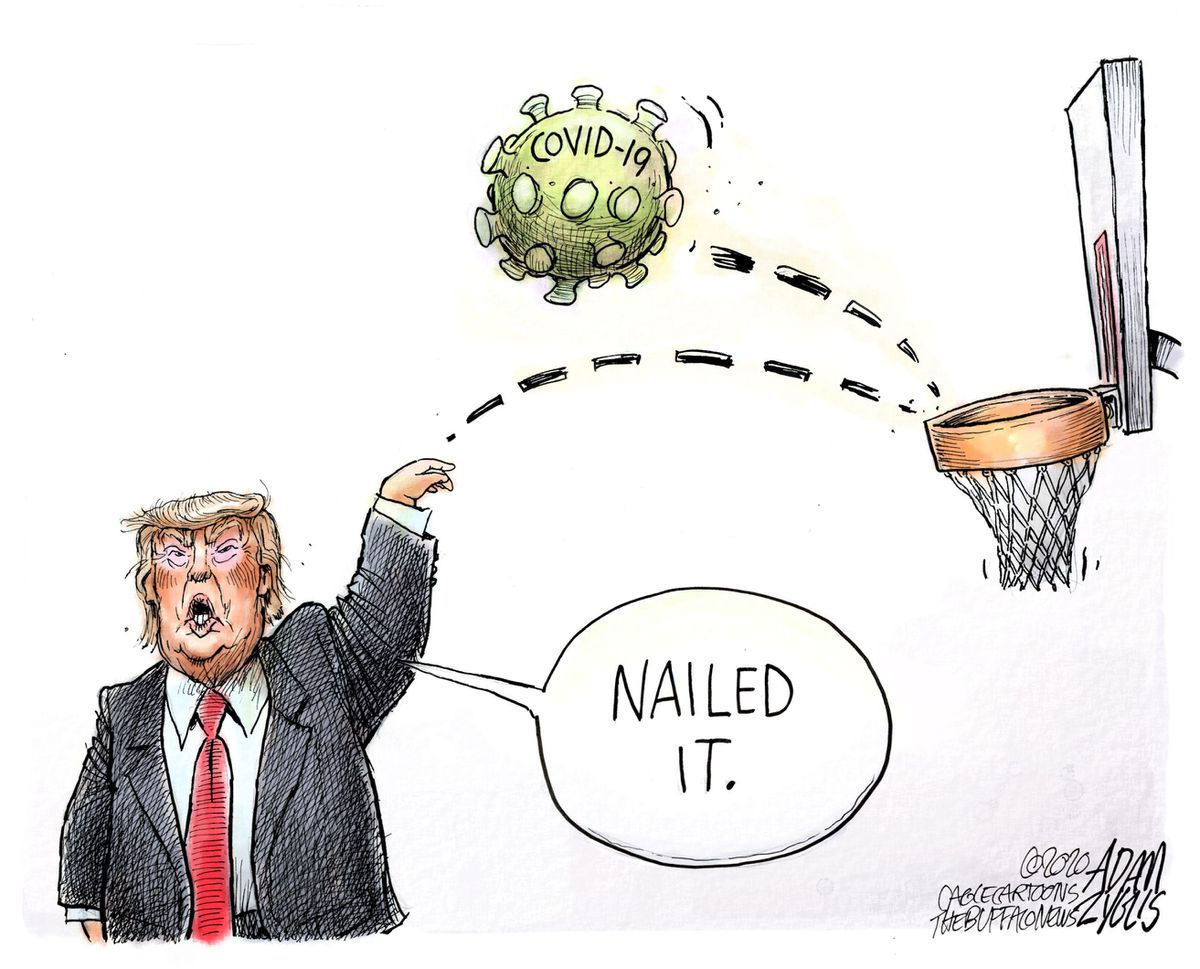

In [5]:
from IPython.display import Image
Image(filename='covid america.jpg') 

## tHaNkS - HS 